In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

In [2]:
image_dir = './Jaws_binary_labeled_images/'


print("Class number:", len(os.listdir(image_dir)))

Class number: 2


In [3]:
# Input image dimensions, etc.
resized_height = 224
resized_width = 224
num_channel = 3 
num_classes = 2
batch_size = 32

In [4]:
train_images = image_dataset_from_directory(
    image_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', image_size=(resized_height ,
    resized_width ), batch_size=batch_size, shuffle=True, seed=42,
    validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

Found 108 files belonging to 2 classes.
Using 87 files for training.


2024-04-23 13:58:27.336292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [5]:
valid_images = image_dataset_from_directory(
    image_dir, labels='inferred', label_mode='categorical',
     color_mode='rgb', image_size=(resized_height ,
    resized_width ), batch_size=32, shuffle=True, seed=42,
    validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False)

Found 108 files belonging to 2 classes.
Using 21 files for validation.


In [6]:
# Initialize empty lists to store images and labels
images = []
labels = []

# Iterate over the dataset to extract images and labels
for image_batch, label_batch in train_images:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

# Concatenate the lists of images and labels
image_array = np.concatenate(images, axis=0)
label_array = np.concatenate(labels, axis=0)

print("Images shape:", image_array.shape)  # Output: (87, 224, 224, 3)
print("Labels shape:", label_array.shape)  # Output: (87, 18)

Images shape: (87, 224, 224, 3)
Labels shape: (87, 2)


In [7]:
def custom_preprocessing_function(image):
    # Randomly select a channel to scale
    channel_to_scale = np.random.randint(0, 3)  # 0 for Red, 1 for Green, 2 for Blue

    # Generate a random scaling factor between 0.5 and 1.5
    scaling_factor = np.random.uniform(0.5, 1.5)

    # Scale the selected channel
    image[:,:,channel_to_scale] *= scaling_factor

    # Clip the values to ensure they remain in the valid range [0, 255]
    image = np.clip(image, 0, 255)

    return image


In [8]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [9]:
augmented_images = datagen.flow(image_array, label_array)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPool2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')
])


# CNNs are more concise and have fewer parameteres than dense layers

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 43264)             0

In [12]:
# Fit the generator on the training data
datagen.fit(image_array)

# Compile the new model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history= model.fit(augmented_images,
          epochs=20,
#          steps_per_epoch=4,
          validation_data=valid_images)

Epoch 1/20


2024-04-23 13:58:38.661794: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-04-23 13:58:40.456113: I external/local_xla/xla/service/service.cc:168] XLA service 0x1496f06f9230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-23 13:58:40.456161: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-04-23 13:58:40.460901: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713895120.558778 2114704 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 7s 1s/step - loss: 44.8822 - accuracy: 0.7356 - val_loss: 31.2374 - val_accuracy: 0.6190
Epoch 2/20
3/3 [==============================] - 1s 534ms/step - loss: 22.8360 - accuracy: 0.7126 - val_loss: 7.8626 - val_accuracy: 0.6190
Epoch 3/20
3/3 [==============================] - 1s 500ms/step - loss: 5.7807 - accuracy: 0.7126 - val_loss: 1.4417 - val_accuracy: 0.6190
Epoch 4/20
3/3 [==============================] - 1s 537ms/step - loss: 1.9106 - accuracy: 0.6092 - val_loss: 0.7620 - val_accuracy: 0.6190
Epoch 5/20
3/3 [==============================] - 1s 438ms/step - loss: 0.7788 - accuracy: 0.7011 - val_loss: 0.7634 - val_accuracy: 0.6190
Epoch 6/20
3/3 [==============================] - 1s 548ms/step - loss: 0.6404 - accuracy: 0.7241 - val_loss: 0.6939 - val_accuracy: 0.6190
Epoch 7/20
3/3 [==============================] - 1s 428ms/step - loss: 0.6851 - accuracy: 0.6897 - val_loss: 0.6473 - val_accuracy: 0.6190
Epoch 8/20
3/3 [===============

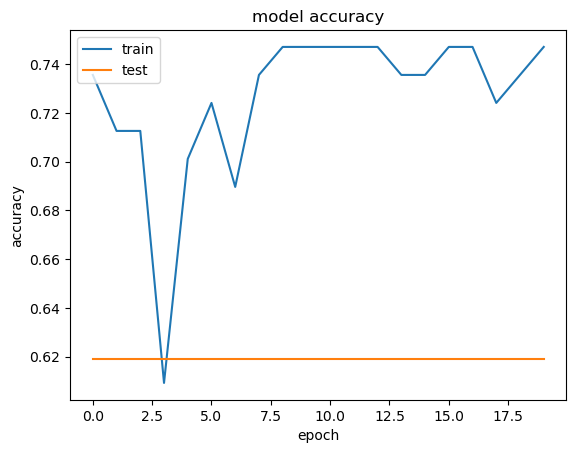

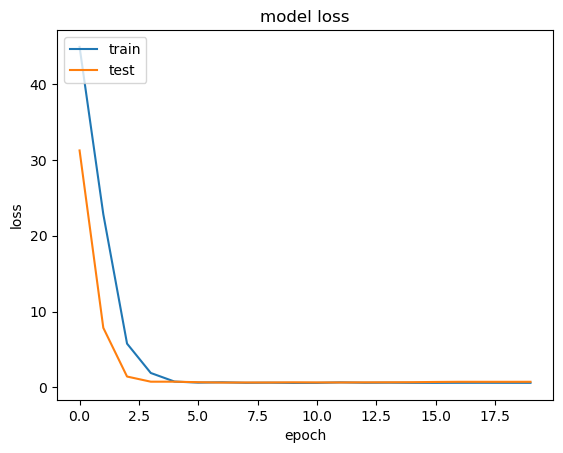

In [14]:
from helpers_plot_history import plot_history
plot_history(history)

In [15]:
np.argmax(model.predict(valid_images), axis = 1)

1/1 [==============================] - 1s 547ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
ytest = np.concatenate([
    y for x, y in valid_images
], axis = 0)
np.argmax(ytest, axis = 1)

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0])

1/1 [==============================] - 0s 484ms/step


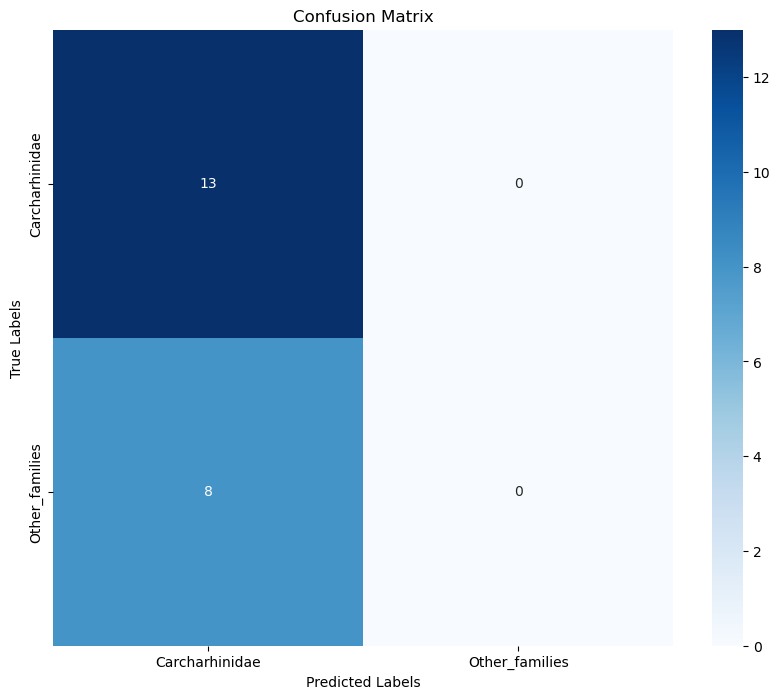

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = train_images.class_names

val_predictions = np.argmax(model.predict(valid_images), axis = 1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
ytest = np.concatenate([
    y for x, y in valid_images
], axis = 0)
true_labels = np.argmax(ytest, axis = 1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Transfer learning

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load the base MobileNetV2 model with weights pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False


# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid') 
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Epoch 1/10
3/3 [==============================] - 8s 769ms/step - loss: 0.7419 - accuracy: 0.7241 - val_loss: 0.8086 - val_accuracy: 0.6190
Epoch 2/10
3/3 [==============================] - 4s 417ms/step - loss: 0.7099 - accuracy: 0.7241 - val_loss: 0.8288 - val_accuracy: 0.6190
Epoch 3/10
3/3 [==============================] - 4s 379ms/step - loss: 0.6783 - accuracy: 0.7586 - val_loss: 0.8155 - val_accuracy: 0.6190
Epoch 4/10
3/3 [==============================] - 5s 541ms/step - loss: 0.6403 - accuracy: 0.7241 - val_loss: 0.7996 - val_accuracy: 0.6190
Epoch 5/10
3/3 [==============================] - 5s 398ms/step - loss: 0.6229 - accuracy: 0.7356 - val_loss: 0.7927 - val_accuracy: 0.6190
Epoch 6/10
3/3 [==============================] - 4s 715ms/step - loss: 0.6614 - accuracy: 0.7471 - val_loss: 0.7858 - val_accuracy: 0.6190
Epoch 7/10
3/3 [==============================] - 4s 415ms/step - loss: 0.6464 - accuracy: 0.7471 - val_loss: 0.7652 - val_accuracy: 0.6190
Epoch 8/10
3/3 [====

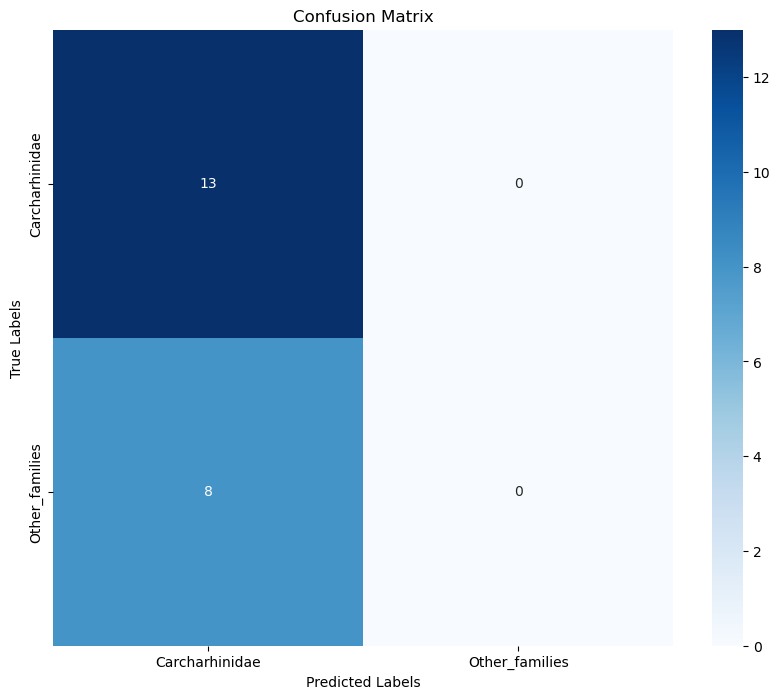

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_images,
    epochs=10,
    validation_data=valid_images,
    callbacks=[early_stopper]
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(valid_images)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

class_names = train_images.class_names

val_predictions = np.argmax(model.predict(valid_images), axis = 1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
ytest = np.concatenate([
    y for x, y in valid_images
], axis = 0)
true_labels = np.argmax(ytest, axis = 1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ResNet50

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20
3/3 [==============================] - 8s 1s/step - loss: 0.7609 - accuracy: 0.6667 - val_loss: 1.1955 - val_accuracy: 0.6190
Epoch 2/20
3/3 [==============================] - 6s 572ms/step - loss: 0.6814 - accuracy: 0.7701 - val_loss: 1.0468 - val_accuracy: 0.6190
Epoch 3/20
3/3 [==============================] - 3s 304ms/step - loss: 0.6075 - accuracy: 0.7586 - val_loss: 0.8226 - val_accuracy: 0.5714
Epoch 4/20
3/3 [==============================] - 4s 567ms/step - loss: 0.3787 - accuracy: 0.8161 - val_loss: 0.8203 - val_accuracy: 0.5714
Epoch 5/20
3/3 [==============================] - 5s 295ms/step - loss: 0.4864 - accuracy: 0.7931 - val_loss: 0.9177 - val_accuracy: 0.5714
Epoch 6/20
3/3 [==============================] - 4s 277ms/step - loss: 0.3858 - accuracy: 0.8621 - val_loss: 1.0371 - val_accuracy: 0.5714
Epoch 7/20
3/3 [==============================] - 6s 370ms/step - loss: 0.2691 - accuracy: 0.9195 

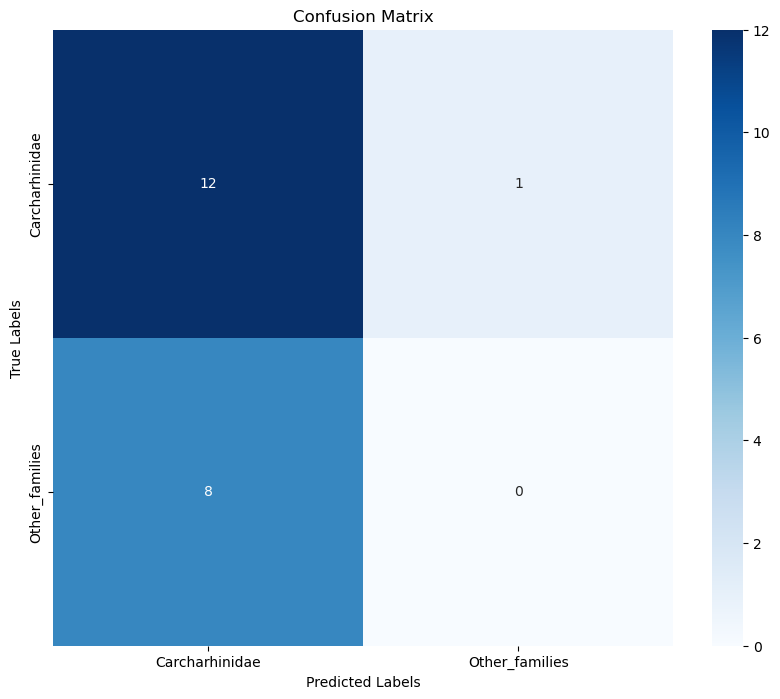

In [23]:
from tensorflow.keras.applications import ResNet50

# Load the base ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(
    train_images,
    epochs=20,
    validation_data=valid_images,
    callbacks=[early_stopper]
)

val_loss, val_accuracy = model.evaluate(valid_images)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

class_names = train_images.class_names

val_predictions = np.argmax(model.predict(valid_images), axis = 1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
ytest = np.concatenate([
    y for x, y in valid_images
], axis = 0)
true_labels = np.argmax(ytest, axis = 1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# MobileNet

Epoch 1/20
3/3 [==============================] - 7s 703ms/step - loss: 1.1379 - accuracy: 0.3218 - val_loss: 0.7261 - val_accuracy: 0.4762
Epoch 2/20
3/3 [==============================] - 4s 290ms/step - loss: 0.7837 - accuracy: 0.5057 - val_loss: 0.7202 - val_accuracy: 0.6190
Epoch 3/20
3/3 [==============================] - 4s 307ms/step - loss: 0.6647 - accuracy: 0.7356 - val_loss: 0.8296 - val_accuracy: 0.6190
Epoch 4/20
3/3 [==============================] - 4s 384ms/step - loss: 0.6093 - accuracy: 0.7586 - val_loss: 0.9216 - val_accuracy: 0.6190
Epoch 5/20
3/3 [==============================] - 5s 519ms/step - loss: 0.7142 - accuracy: 0.7471 - val_loss: 0.9637 - val_accuracy: 0.6190
Epoch 6/20
3/3 [==============================] - 8s 398ms/step - loss: 0.6625 - accuracy: 0.7471 - val_loss: 0.9458 - val_accuracy: 0.6190
Epoch 7/20
1/1 [==============================] - 1s 514ms/step - loss: 0.7202 - accuracy: 0.6190
Validation loss: 0.7202149033546448
Validation accuracy: 0.619

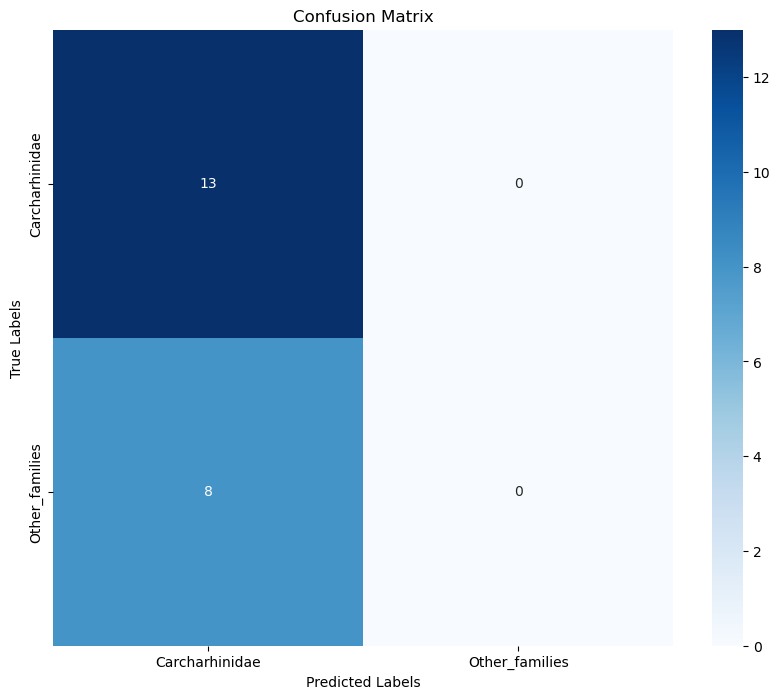

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load the base MobileNetV2 model with weights pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create a new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(
    train_images,
    epochs=20,
    validation_data=valid_images,
    callbacks=[early_stopper]
)

val_loss, val_accuracy = model.evaluate(valid_images)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_accuracy)

class_names = train_images.class_names

val_predictions = np.argmax(model.predict(valid_images), axis = 1)  # Convert probabilities to class indices

# Convert one-hot encoded labels to class indices
ytest = np.concatenate([
    y for x, y in valid_images
], axis = 0)
true_labels = np.argmax(ytest, axis = 1)  # Convert from one-hot to class indices

# Compute the confusion matrix
conf_mat = confusion_matrix(true_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()